Loading dataset images...
Training set: 9 images
Image shape: (128, 128, 3)
Training CNN model...
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7500 - loss: 0.7291
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6343 - loss: 0.7564
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5810 - loss: 0.6018
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7037 - loss: 0.3799
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7037 - loss: 0.4207


Model saved as 'product_damage_cnn.h5'

Please upload a test image (e.g., nodam (2).jpeg) to check for damage.


Saving download.jpeg to download (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


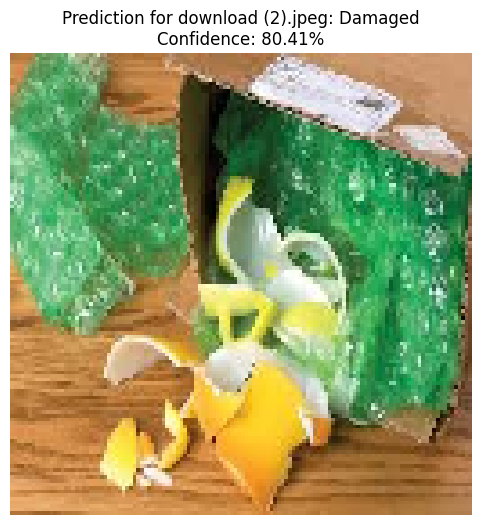


Prediction for download (2).jpeg: Damaged (Confidence: 80.41%)
Prediction result saved as 'prediction_result.txt'


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab import files

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create dataset directories
os.makedirs('dataset/Not_Damaged', exist_ok=True)
os.makedirs('dataset/Damaged', exist_ok=True)

# Create placeholder images for minimal dataset
# Not Damaged: solid green image
not_damaged_img = np.zeros((128, 128, 3), dtype=np.uint8)
not_damaged_img[:, :, 1] = 255  # Green channel
Image.fromarray(not_damaged_img).save('dataset/Not_Damaged/not_damaged.jpg')

# Damaged: red image with white scratches
damaged_img = np.zeros((128, 128, 3), dtype=np.uint8)
damaged_img[:, :, 0] = 255  # Red channel
damaged_img[50:70, 30:90, :] = 255  # White scratch
damaged_img[80:100, 50:110, :] = 255  # Another white scratch
Image.fromarray(damaged_img).save('dataset/Damaged/damaged.jpg')

# Define paths
data_dir = 'dataset'
not_damaged_dir = os.path.join(data_dir, 'Not_Damaged')
damaged_dir = os.path.join(data_dir, 'Damaged')

# Function to load and preprocess images
def load_images_from_folder(folder_path, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = tf.keras.utils.load_img(img_path, target_size=img_size)
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.cast(img_array, tf.float32) / 255.0  # Normalize to [0,1]
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset images
print("Loading dataset images...")
not_damaged_images, not_damaged_labels = load_images_from_folder(not_damaged_dir, 0)  # 0: Not Damaged
damaged_images, damaged_labels = load_images_from_folder(damaged_dir, 1)  # 1: Damaged

# Combine datasets
X = np.vstack((not_damaged_images, damaged_images))
y = np.hstack((not_damaged_labels, damaged_labels))

print(f"Training set: {X.shape[0]} images")
print(f"Image shape: {X.shape[1:]}")

# Data augmentation to improve generalization
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Build the CNN model (slightly deeper)
def create_cnn_model(input_shape=(128, 128, 3), num_classes=2):
    model = keras.Sequential([
        # Data augmentation
        data_augmentation,
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train the model
print("Training CNN model...")
model = create_cnn_model()
model.fit(
    X, y,
    epochs=5,  # Increased epochs for augmentation
    batch_size=2,  # Small batch size
    verbose=1
)

# Save the model
model.save('product_damage_cnn.h5')
print("Model saved as 'product_damage_cnn.h5'")

# Prompt user to upload a test image
print("\nPlease upload a test image (e.g., nodam (2).jpeg) to check for damage.")
uploaded = files.upload()

# Process the uploaded test image
test_img_name = list(uploaded.keys())[0] if uploaded else None
if not test_img_name or not test_img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
    raise ValueError("No valid image file uploaded. Please upload a .jpg, .jpeg, or .png file.")

test_img_path = test_img_name
test_img = tf.keras.utils.load_img(test_img_path, target_size=(128, 128))
test_array = tf.keras.utils.img_to_array(test_img)
test_array = tf.cast(test_array, tf.float32) / 255.0
test_array = np.expand_dims(test_array, axis=0)  # Add batch dimension
prediction = model.predict(test_array)
pred_label = 'Not Damaged' if np.argmax(prediction) == 0 else 'Damaged'
confidence = np.max(prediction) * 100

# Display the test image and prediction
plt.figure(figsize=(6, 6))
plt.imshow(test_img)
plt.title(f'Prediction for {test_img_name}: {pred_label}\nConfidence: {confidence:.2f}%')
plt.axis('off')
plt.show()

print(f"\nPrediction for {test_img_name}: {pred_label} (Confidence: {confidence:.2f}%)")

# Save prediction result to a text file
with open('prediction_result.txt', 'w') as f:
    f.write(f"Test Image: {test_img_name}\n")
    f.write(f"Prediction: {pred_label}\n")
    f.write(f"Confidence: {confidence:.2f}%\n")
    f.write(f"Date: 2025-09-30 15:41 IST\n")
print("Prediction result saved as 'prediction_result.txt'")